# Autoencoder

In [1]:
import sys
import os
sys.path.insert(0, '../../..')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

import numpy as np
import tensorflow as tf
import keras
import keras.ops as K
from keras.optimizers import Adam

import wandb
from wandb.integration.keras import WandbMetricsLogger

from src.utils.loaders import load_mnist
from src.models.AE import Autoencoder
from utils.wandb_utils import init_wandb
from utils.callbacks import LRFinder, get_lr_scheduler, get_early_stopping

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)


2025-12-31 16:19:10.423512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Global Configuration
BATCH_SIZE = 1024 # Optimized for 8GB VRAM
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0
INPUT_DIM = (28,28,1)
Z_DIM = 2
OPTIMIZER_NAME = 'adam'
DATASET_NAME = 'digits'
MODEL_TYPE = 'autoencoder'

# Run Params
SECTION = 'vae'
RUN_ID = '0001'
RUN_FOLDER = '../run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATASET_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER, exist_ok=True)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build'


## Set parameters

In [3]:
# Initialize W&B
run = init_wandb(
    name="03_01_autoencoder",
    project="generative-deep-learning",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "learning_rate": "auto",
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": OPTIMIZER_NAME,
    }
)


wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load the data

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Define the structure of the neural network

In [5]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.weights.h5'))

I0000 00:00:1767197968.341787     715 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
AE.encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_0 (Conv2D)         │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_1 (Conv2D)         │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_2 (Conv2D)         │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_3 (Conv2D)         │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         6,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,946 (386.51 KB)

 Trainable params: 98,946 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
AE.decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,017 (398.50 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 0 (0.00 B)

## Train the autoencoder

2025-12-31 16:19:38.893581: I external/local_xla/xla/service/service.cc:163] XLA service 0x7651bc0480b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-31 16:19:38.893664: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-12-31 16:19:39.092589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-31 16:19:39.685876: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-31 16:19:40.580084: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1024,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

Optimal Learning Rate (Recommended): 0.000133


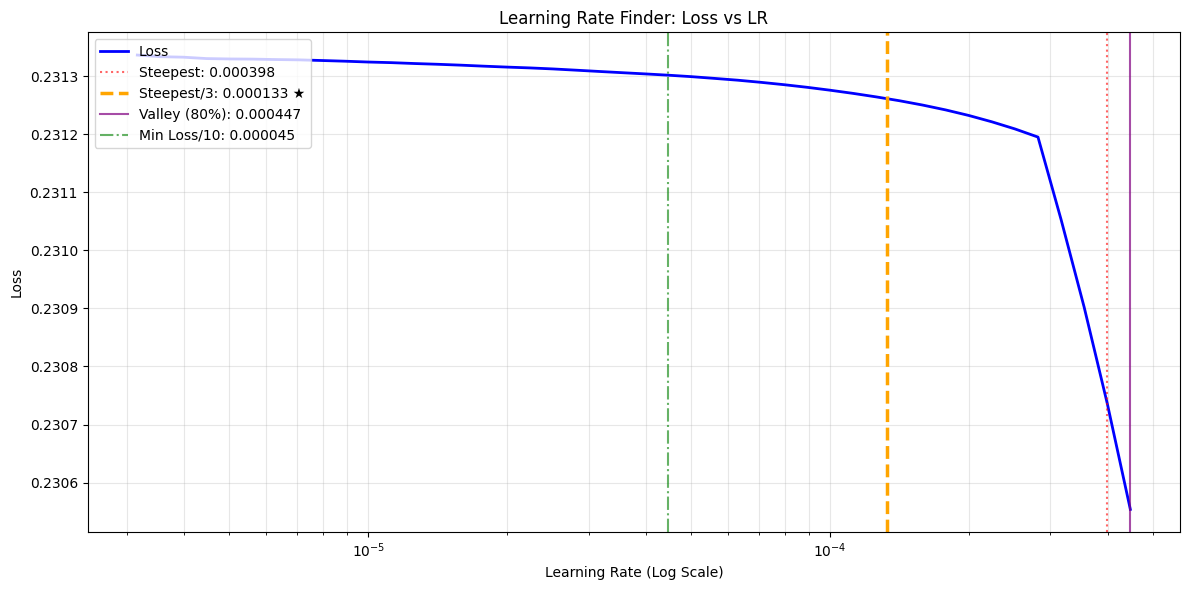

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.000398  (aggressive)
  🟠 Steepest / 3      : 0.000133  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.000447  (robust)
  🟢 Min Loss / 10     : 0.000045  (conservative)
  Selected Method: 'recommended' → LR = 0.000133
Optimal LR: 0.00013270238802457848


In [8]:
# Learning Rate Finder

# Clone the model to avoid pre-training the actual model
lr_model = tf.keras.models.clone_model(AE.model)

# Define reconstruction loss locally as expected by LRFinder/Keras
def r_loss_lr(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

lr_opt = Adam(learning_rate=1e-6)
lr_model.compile(loss=r_loss_lr, optimizer=lr_opt)

lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)
lr_model.fit(x_train, x_train,
             batch_size=BATCH_SIZE,
             steps_per_epoch=50,
             epochs=2,
             callbacks=[lr_finder],
             verbose=0)

lr_finder.plot_loss()
optimal_lr = lr_finder.get_optimal_lr()
print(f"Optimal LR: {optimal_lr}")

# Update W&B
wandb.config.update({"learning_rate": optimal_lr})


In [9]:
AE.compile(optimal_lr)


In [10]:
# Re-define callbacks ensuring they exist
from utils.wandb_utils import get_model_checkpoint
from utils.callbacks import get_lr_scheduler, get_early_stopping, LRLogger
from wandb.integration.keras import WandbMetricsLogger

wandb_metrics_logger = WandbMetricsLogger()
# Using ReduceLROnPlateau scheduler
lr_scheduler = get_lr_scheduler(monitor='loss', patience=5)
lr_logger = LRLogger()
early_stopping = get_early_stopping(monitor='loss', patience=10)

# Train the model using AE.train with custom callbacks
# lr_decay=1 disables the built-in step decay scheduler in favor of ReduceLROnPlateau
AE.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    initial_epoch=INITIAL_EPOCH,
    lr_decay=1,
    extra_callbacks=[
        wandb_metrics_logger,
        lr_scheduler,
        lr_logger,
        early_stopping
    ]
)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2221
Epoch 1: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 1: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 1: Learning Rate is 1.33e-04
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.1939 - learning_rate: 1.3270e-04
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0883
Epoch 2: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 2: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 2: Learning Rate is 1.33e-04
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0806 - learning_rate: 1.3270e-04
Epoch 3/200
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0707
Epoch 3: saving model to ../run/vae/0001_digits/weights/weights.weights.h5

Epoch 3: finished saving model to ../run/vae/0001_digits/weights/weights.weights.h5
Epoch 3: Learning Rate is 1.33e-04
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - lo

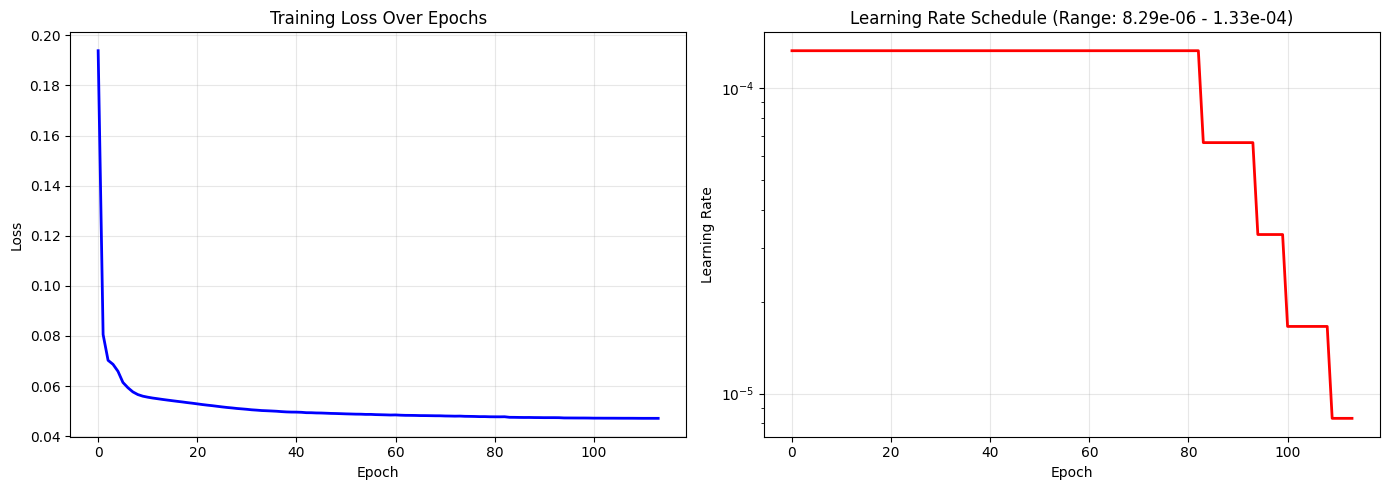

Current Optimizer LR: 4.15e-06
               TRAINING SUMMARY
  Initial Loss  : 0.193871
  Final Loss    : 0.047107
  Min Loss      : 0.047107 (Epoch 114)
  Improvement   : 75.7%
  Total Epochs  : 114
  Logged LR     : 8.29e-06 (from history)


In [11]:
# Plot training history with improved visualization
import matplotlib.pyplot as plt
import numpy as np

history = AE.model.history.history

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss
axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Epochs')
axes[0].grid(True, alpha=0.3)

# Plot 2: Learning Rate with better handling
if 'learning_rate' in history:
    lr_data = np.array(history['learning_rate'])
    lr_min, lr_max = lr_data.min(), lr_data.max()
    lr_range = lr_max - lr_min
    
    if lr_range > 1e-10:  # LR actually changed
        axes[1].semilogy(lr_data, 'r-', linewidth=2)
        axes[1].set_title(f'Learning Rate Schedule (Range: {lr_min:.2e} - {lr_max:.2e})')
    else:  # LR was constant
        axes[1].plot(lr_data, 'r-', linewidth=2)
        axes[1].set_ylim([lr_min * 0.5, lr_max * 1.5])  # Add padding
        axes[1].set_title(f'Learning Rate (Constant: {lr_data[0]:.2e})')
        axes[1].text(0.5, 0.95, 'Note: ReduceLROnPlateau changes may not be logged in history',
                     transform=axes[1].transAxes, fontsize=9, ha='center', va='top',
                     style='italic', color='gray')
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'LR not tracked in history', ha='center', va='center')

plt.tight_layout()
plt.show()

# Get actual current LR from optimizer
try:
    current_lr = float(AE.model.optimizer.learning_rate)
    print(f"Current Optimizer LR: {current_lr:.2e}")
except:
    pass

# Print summary
print(f"{'='*55}")
print('               TRAINING SUMMARY')
print(f"{'='*55}")
print(f"  Initial Loss  : {history['loss'][0]:.6f}")
print(f"  Final Loss    : {history['loss'][-1]:.6f}")
print(f"  Min Loss      : {min(history['loss']):.6f} (Epoch {history['loss'].index(min(history['loss'])) + 1})")
print(f"  Improvement   : {((history['loss'][0] - history['loss'][-1]) / history['loss'][0] * 100):.1f}%")
print(f"  Total Epochs  : {len(history['loss'])}")
if 'learning_rate' in history:
    print(f"  Logged LR     : {history['learning_rate'][-1]:.2e} (from history)")
print(f"{'='*55}")


In [12]:
# Robust WandB finish
try:
    if wandb.run is not None:
        wandb.finish()
        print('WandB run finished successfully.')
except Exception as e:
    print(f'Error finishing WandB run: {e}')


epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,███████████████████████████████▄▄▄▄▂▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████████████████████████▄▄▄▄▄▂▂▁▁▁
epoch/epoch,113
epoch/learning_rate,1e-05
epoch/loss,0.04711
learning_rate,0.0


WandB run finished successfully.


# Cleanup: Restart Kernel to Release GPU Memory

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
# Run this cell only after all work is complete and saved.

import IPython
print("Restarting kernel to release GPU memory...")
IPython.Application.instance().kernel.do_shutdown(restart=True)